In [101]:
import nibabel as nib
import numpy as np
import pandas as pd 
import nilearn
from nilearn import plotting
from fragmenter import Fragment
from fragmenter import adjacency
from fragmenter import RegionExtractor

In [141]:
%matplotlib inline

In [138]:
cd ../

C:\Users\Amanda\Desktop\parcellation_fragmenter


In [142]:
from os.path import join
label_file = join('data', 'freesurfer', 'fsaverage', 'surf', 'rh.inflated')

This is a simple demo of the parcellation fragmenter, from simple use to some benchmarks. The first step is to load a template surface (in this case, the inflated fsaverage). Use your own path_to_data to

In [143]:
testSurface = nib.freesurfer.read_geometry(label_file)

Surfaces are a 2D triangular mesh, so that each data-containing vertex is tied to 2 neighbors by a triangle. When loading it, you get a tuple of two arrays: the coordinates of each vertex and the vertex's direct neighbors (faces).

In [144]:
testSurface

(array([[ -6.77207661,  10.74224281,  63.36345291],
        [  7.45265865, -43.94926453,  43.67302322],
        [ 40.67627335,   8.6865921 ,  15.46871376],
        ...,
        [ 20.50901985,  -7.89210987, -66.16957092],
        [ 20.29653549,  -8.46869278, -65.95698547],
        [ 20.08860397,  -8.99943542, -65.75714111]]),
 array([[     0,  40964,  40962],
        [     0,  40962,  40965],
        [     0,  40965,  40967],
        ...,
        [163841, 160926,  39990],
        [163113, 160926, 163841],
        [163113,     11, 160926]]))

The fsaverage mesh is composed of ~164k vertices, which we can confirm here.

In [23]:
np.shape(testSurface[0])[0]

163842

In order to parcellate a surface, we derive the neighbors of each vertex. You can consider this to be an adjacency matrix that allows for standard clustering methods to be computed on it. The `adjacency` function will give you this list (in this example, we will just look at the neighbors of vertex 2).

In [24]:
# Create a surface adjacency object
M = adjacency.SurfaceAdjacency(testSurface[0], testSurface[1])

# Generate adjacency list
M.generate()

# Visualize
M.adj[1]

[40992, 150713, 150714, 40989, 40991]

In order to fragment a surface, we first create a `Fragment` object that takes in the desired number of clusters, and whether you want to use pretty colors (True/False). In this case, we will run a simple 10 parcel example.

In [26]:
testFragment = Fragment.Fragment(n_clusters=10)

Once the object is defined, you can check that the number of clusters is right.

In [27]:
testFragment.n_clusters

10

Now we are ready to fit the number of clusters onto the provided surface. Coordinates and vertices are provided separately (meaning that you could just cluster custom, non-cortical meshes). The following example uses mini batch k-means clustering for parcellating our surface. Other clustering algorithms available are Gaussian Mixture Models ('gmm') and Agglomerative Clustering and Ward ('ward').

In [28]:
testFragment.fit(vertices = testSurface[0], faces=testSurface[1], method = 'k_means')

This will add an attribute to `testFragment` called `label_`, which is the parcel label associated with each vertex. We can confirm this by checking that length of the resulting vector is equal to the number of vertices in fsaverage.

In [29]:
np.size(testFragment.label_)

163842

We can also see that the number of labels produced is equal to our desired number of clusters (10).

In [30]:
np.unique(testFragment.label_)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

And now we can plot the 10 parcels onto a surface (**FIX THIS SO WE CAN USE VIEW_SURF INSTEAD**).

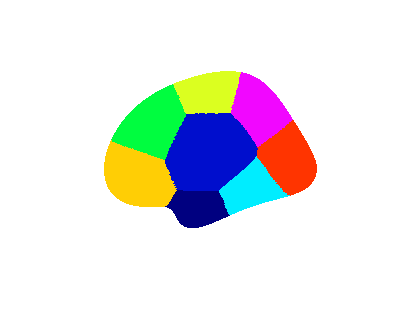

In [113]:
plotting.plot_surf_roi(list(testSurface), testFragment.label_);

**TO ADD**
- ROI-specific parcellation
- Null model explanation (once Kristian finishes implementing the class)

If we want to parcellate based on regions, we can pass the label file (.annot) to map all the vertices of this ROI. Region Extractor generates a dictionary with the FreeSurfer parcellation areas. It tells us which vertices correspond to each brain area. 

In [103]:
#label_file = r'C:\Users\Amanda\Desktop\parcellation_fragmenter\data\freesurfer\fsaverage\label\lh.aparc.annot'
ext = RegionExtractor.Extractor()
label_table = ext.get_label_table(label_file)
#label_table

To parcellate a given brain region, call it from the dictionary created by RegionExtractor using label_table. This returns the vertices associated with the region.

In [95]:
label_table['cuneus']

array([   149,    150,    337, ..., 163679, 163758, 163759], dtype=int64)

In [160]:
#label_table

In [157]:
testRegion = Fragment.Fragment(n_clusters=10)
testRegion.fit(vertices = testSurface[0], faces=testSurface[1], method = 'k_means', parcels = label_table, rois= ['superiortemporal'])

superiortemporal


In [158]:
testRegion.label_

array([0., 0., 0., ..., 0., 0., 0.])

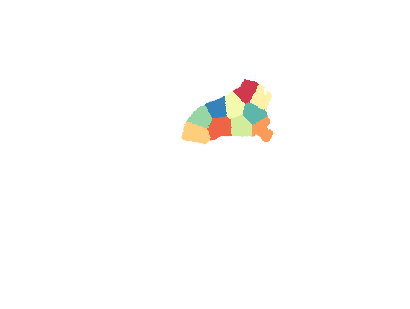

In [159]:
plotting.plot_surf_roi(list(testSurface), testRegion.label_, cmap='Spectral');

In [118]:
testSurface[1].shape

(327680, 3)

In [111]:
np.unique(testRegion.label_)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])